# Density Estimation: Gaussian Mixture Models

Here we'll explore **Gaussian Mixture Models**, which is an ***unsupervised clustering & density estimation technique.***

We'll start with our standard set of initial imports

In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

## Introducing Gaussian Mixture Models

We previously saw an example of K-Means, which is a clustering algorithm which is most often fit using an expectation-maximization approach.

Here we'll consider an extension to this which is suitable for both **clustering** and **density estimation**.

For example, imagine we have some one-dimensional data in a particular distribution:

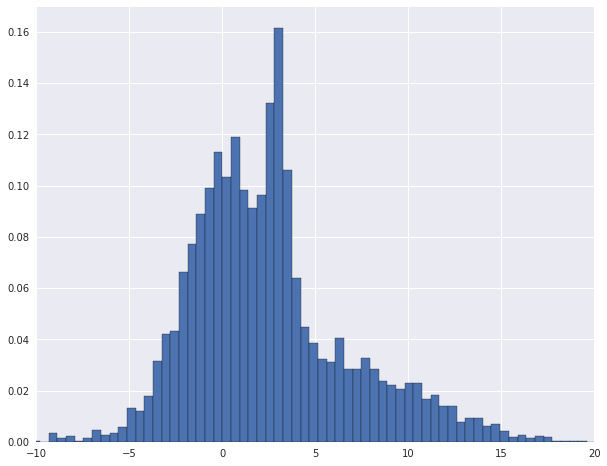

In [54]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
x = np.reshape(x, (-1, 1))
plt.figure(figsize=(10,8))
plt.hist(x, 80, normed=True, ec='black')
plt.xlim(-10, 20);

Gaussian mixture models will allow us to approximate this density:

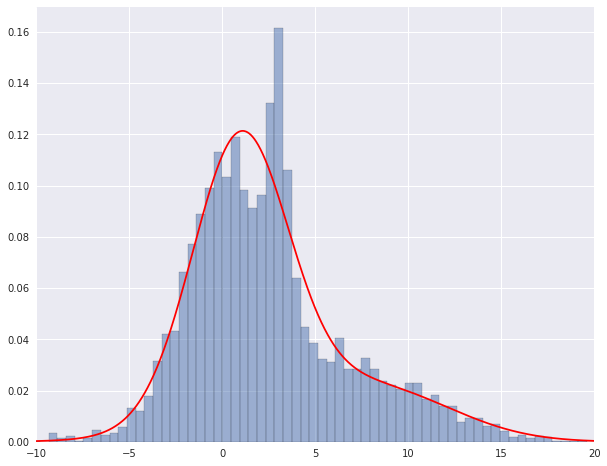

In [55]:
from sklearn.mixture import GMM


clf = GMM(4, n_iter=500, random_state=3).fit(x)
xpdf = np.reshape(np.linspace(-10, 20, 1000), (-1, 1))
clf.score(xpdf)

density = np.exp(clf.score(xpdf))

plt.figure(figsize=(10,8))
plt.hist(x, 80, normed=True, alpha=0.5, ec='black')
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [56]:
clf.means_

array([[ 0.25306823],
       [ 3.96038601],
       [ 1.45350312],
       [ 9.56303626]])

In [57]:
clf.covars_

array([[  6.4601766 ],
       [ 23.19014431],
       [  5.80884786],
       [ 14.79998213]])

In [58]:
clf.weights_

array([ 0.31823886,  0.21876416,  0.35341345,  0.10958354])

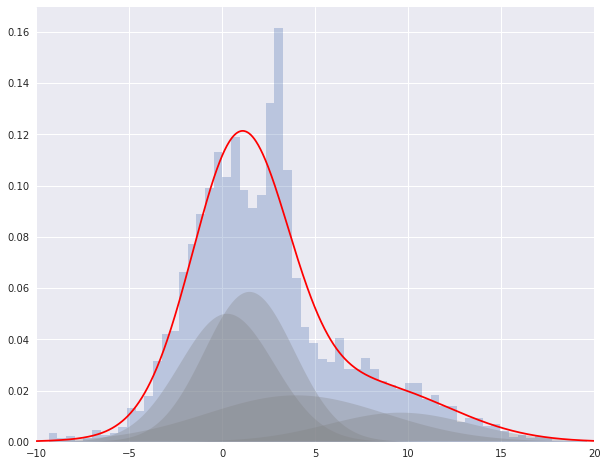

In [59]:
plt.figure(figsize=(10,8))
plt.hist(x, 80, normed=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covars_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

These individual Gaussian distributions are fit using an expectation-maximization method
 - much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.


- Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

## How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data.
For example, there is the Aikaki Information Criterion (AIC) and the Bayesian Information Criterion (BIC)

In [60]:
print(clf.bic(x))
print(clf.aic(x))

25911.1937804
25840.421853


Let's take a look at these as a function of the number of gaussians:

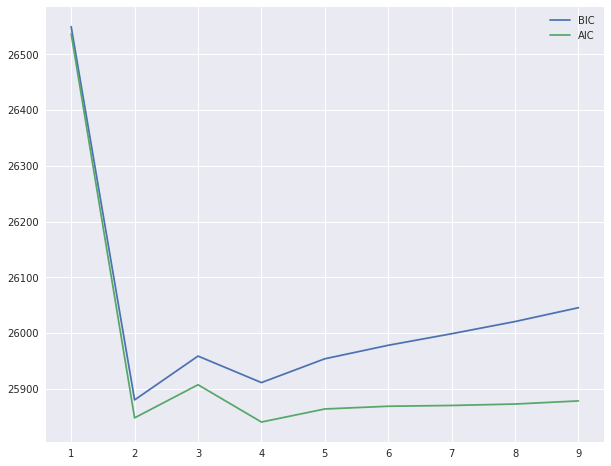

In [61]:
n_estimators = np.arange(1, 10)
clfs = [GMM(n, n_iter=1000).fit(x) for n in n_estimators]
bics = [clf.bic(x) for clf in clfs]
aics = [clf.aic(x) for clf in clfs]

plt.figure(figsize=(10,8))
plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

It appears that for both the AIC and BIC, 4 components is preferred.

## Example: GMM For Outlier Detection

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.

- One thing that generative models can be useful for is **outlier detection**: we can simply evaluate the likelihood of each point under the generative model
    - the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [79]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
tmp = np.reshape((50 * np.random.randn(20)), (-1, 1))
y[true_outliers] += 50 * np.reshape(np.random.randn(20), (-1, 1))

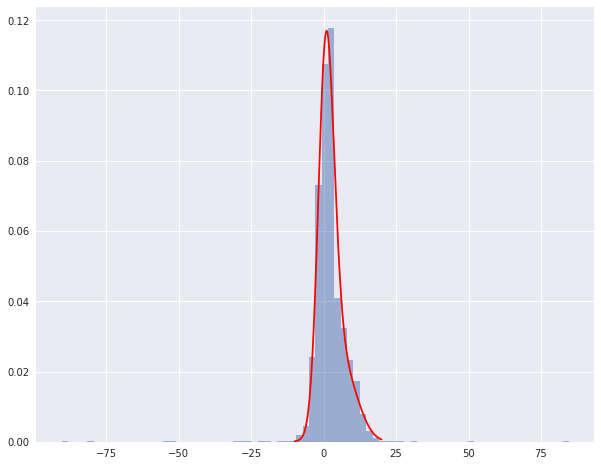

In [80]:
clf = GMM(4, n_iter=500, random_state=0).fit(y)
xpdf = np.reshape(np.linspace(-10, 20, 1000), (-1, 1))
density_noise = np.exp(clf.score(xpdf))

plt.figure(figsize=(10,8))
plt.hist(y, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
#plt.xlim(-10, 20);

Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

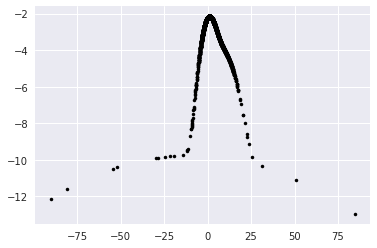

In [81]:
log_likelihood = clf.score_samples(y)[0]
plt.plot(y, log_likelihood, '.k');

In [82]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607 2732
 2893 2897 3264 3468 4373]

detected outliers:
[  99  537 1033 1653 1701 1871 2046 2135 2163 2732 2893 3067 3173 3253 3264
 3468 3483 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed:

In [83]:
set(true_outliers.flatten()) - set(detected_outliers)

{705, 2222, 2496, 2599, 2607, 2897}

And here are the non-outliers which were spuriously labeled outliers:

In [84]:
set(detected_outliers) - set(true_outliers)

{3067, 3173, 3253, 3483}

## Other Density Estimators

The other main density estimator that you might find useful is *Kernel Density Estimation*, which is available via ``sklearn.neighbors.KernelDensity``. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of *every* training point!

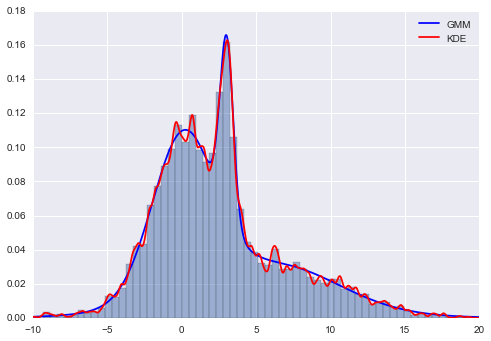

In [16]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend();

All of these density estimators can be viewed as **Generative models** of the data: that is, that is, the model tells us how more data can be created which fits the model.

<small><i>Reference [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>